In [1]:
import pyvisa as pv
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def FindInstrument():
    instrument_name = list(filter(lambda x: 'USB0::0x1AB1::0x04CE::DS1ZD212100403::INSTR' in x,
                                  all_instruments))  # USB0::0x1AB1::0x04CE::DS1ZD212100403::INSTR адрес прибора. Если используете другой прибор, то посмотрите вывод строки print(all_instruments)
    if len(instrument_name) == 0:
        print('Осциллограф не найден в списке устройств')
    else:
        print('Осциллограф найден!')
        print('Адрес:', instrument_name[0])
        return instrument_name[0]

rm = pv.ResourceManager()  # вызывает менеджер работы
all_instruments = rm.list_resources()  # показывает доступные порты передачи данных,имя которых по дефолту заканчивается на ::INSTR. USB RAW и TCPIP SOCKET не выводятся, но чтобы их посмотерть: '?*' в аргумент list_resources()
rigol = rm.open_resource(FindInstrument())

Осциллограф найден!
Адрес: USB0::0x1AB1::0x04CE::DS1ZD212100403::INSTR


frame duration =  480.0 us


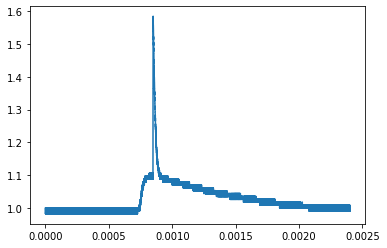

In [49]:
rigol.write(':ACQ:MDEP 24000000')

rigol.write(':STOP')
rigol.write(':WAV:SOUR CHAN1')
rigol.write(':WAV:MODE RAW')
rigol.write('"WAV:FORM BYTE')

params_raw = rigol.query(':WAV:PRE?').split(',')
params = {
    'format': int(params_raw[0]), # 0 - BYTE, 1 - WORD, 2 - ASC 
    'type': int(params_raw[1]), # 0 - NORMal, 1 - MAXimum, 2 RAW
    'points': int(params_raw[2]), # between 1 and 240000000
    'count': int(params_raw[3]), # the number of averages in the average sample mode and 1 in other modes
    'xincrement': float(params_raw[4]), # the time difference brtween two neighboring points in the X direction
    'xorigin': float(params_raw[5]), # the start time of the waveform data in the X direction
    'xreference': float(params_raw[6]), # the reference time of the data point in the X direction
    'yincrement': float(params_raw[7]), # the waveform increment in the Y direction
    'yorigin': float(params_raw[8]), # the vertical offset relative to the "Vertical Reference Position" in the Y direction
    'yreference': float(params_raw[9]) #the vertical reference position in the Y direction
}

data_points_amount = 240000
data_chunks_amount = 5
data_start = (int(params['points']/data_points_amount/2) - 2) * data_points_amount

sample_rate = float(rigol.query(':ACQ:SRAT?'))
frame_duration = data_points_amount/sample_rate # длительность кадра считывания

print('frame duration = ', frame_duration * 1000000, 'us')

data = np.zeros(data_chunks_amount*data_points_amount)
for i in range(data_chunks_amount):
    rigol.write(':WAV:STAR ' + str(i * data_points_amount + 1 + data_start))
    rigol.write(':WAV:STOP ' + str((i + 1) * data_points_amount + data_start))

    rigol.write(':WAV:DATA?')
    data_chunk = np.frombuffer(rigol.read_raw(), dtype=np.int8)

    data_chunk = (data_chunk - params['xreference'] - params['yorigin']) * params['yincrement']
    data_chunk[-1] = data_chunk[-2] # убираем битый пиксель
    data[i*data_points_amount:data_points_amount*(i+1)] += data_chunk[12:]
rigol.write(':RUN')

x_data = np.arange(0, params['xincrement']*data[11:].size, params['xincrement'])

plt.plot(x_data, data[11:])
plt.show()

In [3]:
print('Memory depth', rigol.query(':ACQ:MDEP?'))
print('Sample rate ', rigol.query(':ACQ:SRAT?'))
print('Horizontal time base', rigol.query(':TIM:SCAL?'))
print('Preamble', rigol.query(':WAV:PRE?'))
print('Start point', rigol.query(':WAV:STAR?'))
print('Stop point', rigol.query(':WAV:STOP?'))
rigol.write(':RUN')

Memory depth 24000000

Sample rate  1.000000e+09

Horizontal time base 2.0000000e-04

Preamble 0,0,1200,1,2.000000e-06,-1.736000e-03,0,1.420000e-02,-8,127

Start point 1

Stop point 1200



6

In [42]:
params = rigol.query(':WAV:PRE?').split(',')
print(type(params))
print(float(params[4]))
print(type(float(params[4])))

<class 'list'>
2e-06
<class 'float'>
